In [ ]:
!pip uninstall python-louvain -y
!pip uninstall community -y

import sys
if 'community' in sys.modules:
    del sys.modules['community']

Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Successfully uninstalled python-louvain-0.16
Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Successfully uninstalled community-1.0.0b1


In [ ]:
# Instala a dependência Louvain com o gerenciador de sistema
!apt-get install liblapack-dev
!pip install python-louvain

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
liblapack-dev is already the newest version (3.10.0-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
  Using cached python_louvain-0.16-py3-none-any.whl


In [ ]:
!pip install wikipedia requests beautifulsoup4 networkx nxviz python-louvain pandas matplotlib seaborn tqdm lxml


In [ ]:
# 1. Importações e configurações
import time
import wikipedia
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import deque
from operator import itemgetter
import time
import community as community_louvain


In [ ]:
print(dir(community_louvain))

['__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'best_partition', 'generate_dendrogram', 'induced_graph', 'load_binary', 'modularity', 'partition_at_level']


Coletando seed: Python (programming language)


/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Seed Python (programming language): nós=1224, arestas=1728
Coletando seed: COVID-19
Seed COVID-19: nós=764, arestas=2143
Coletando seed: Photosynthesis
Seed Photosynthesis: nós=0, arestas=0
Coletando seed: Energy crisis
Seed Energy crisis: nós=876, arestas=2417
Coletando seed: Eclipse
Seed Eclipse: nós=601, arestas=2497
Grafo mesclado: nós=3364, arestas=8785
Após limpeza: nós=3356, arestas=8777
Calculando métricas... isso pode demorar dependendo do tamanho do grafo
CSV de métricas salvo: metrics_wiki_tech.csv
GEXF salvo: wiki_tech_merged.gexf


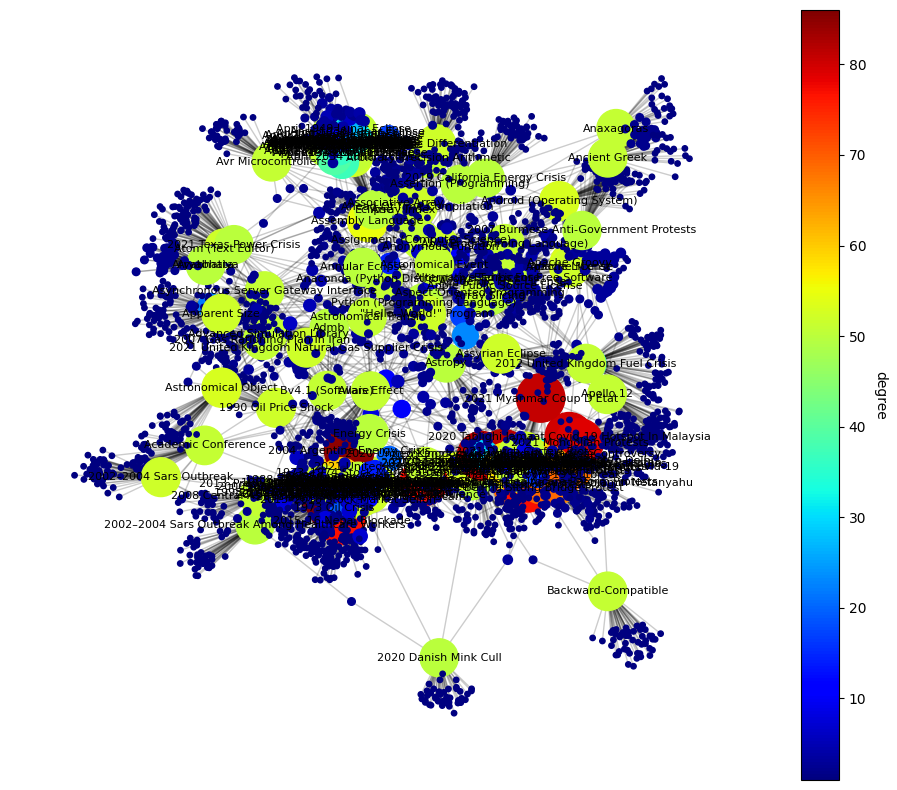

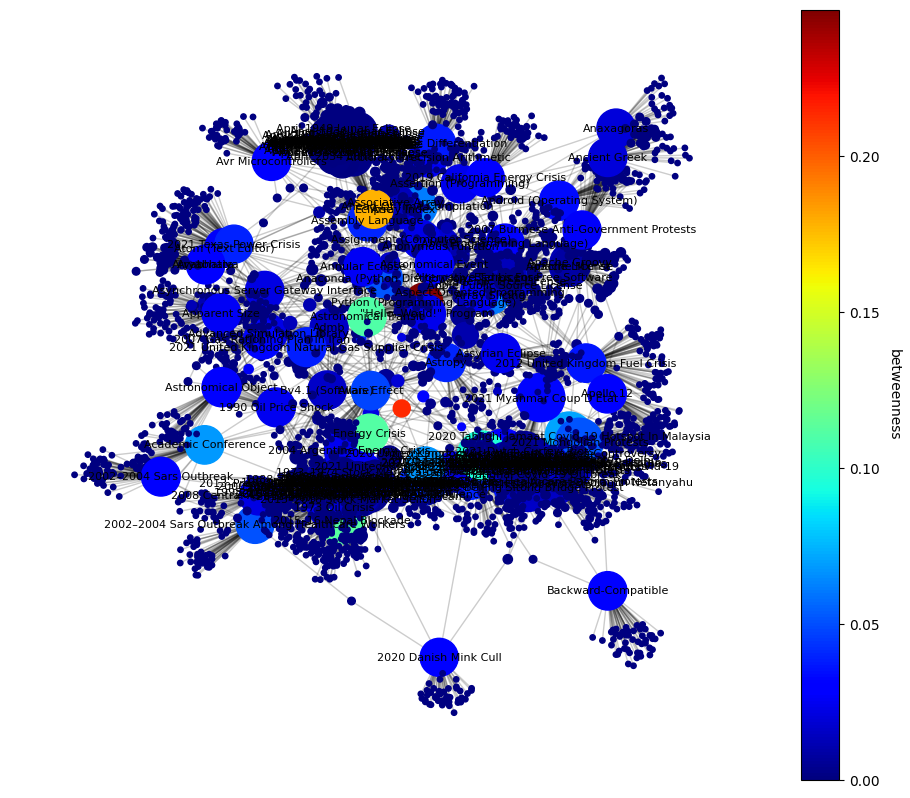

Abra wiki_tech_merged.gexf no Gephi. Use 'Partition' para colorir por 'community' e 'Ranking' para tamanho por 'degree' ou 'degree_centrality'. Use Force Atlas 2 para layout e exporte figuras para o relatório.
Roteiro (sugestão - 12 minutos):

1) Introdução (1 min): apresentar objetivo e seeds escolhidas.
2) Metodologia (2 min): explicar crawler, profundidade, heurística (MAX_LINKS_PER_PAGE), mesclagem.
3) Estatísticas básicas (2 min): nós, arestas, distribuição de grau.
4) Métricas centrais (3 min): mostrar degree, closeness, betweenness, eigenvector (imagens geradas).
5) K-core / K-shell (1 min): mostrar figura e explicar importância.
6) Comunidades (1 min): mostrar particionamento Louvain e interpretação.
7) Conclusão (1 min): limitações e possíveis melhorias.

README criado: README_trabalho_final.md
Notebook pronto. Revise parâmetros (MAX_LINKS_PER_PAGE, MAX_DEPTH, SEEDS) antes de rodar para ajustar tamanho do grafo.


In [ ]:
# parâmetros gerais
SEEDS = [
    "Python (programming language)",
    "COVID-19",
    "Photosynthesis",
    "Energy crisis",
    "Eclipse"
]
MAX_DEPTH = 2            # altura < 3
MAX_LINKS_PER_PAGE = 50  # heurística para evitar explosão
REQUEST_SLEEP = 0.2
STOPS = (
    "International Standard Serial Number",
    "International Standard Book Number",
    "National Diet Library",
    "International Standard Name Identifier",
    "International Standard Book Number (Identifier)",
    "Pubmed Identifier",
    "Pubmed Central",
    "Digital Object Identifier",
    "Arxiv",
    "Proc Natl Acad Sci Usa",
    "Bibcode",
    "Library Of Congress Control Number",
    "Jstor",
    "Doi (Identifier)",
    "Isbn (Identifier)",
    "Pmid (Identifier)",
    "Arxiv (Identifier)",
    "Bibcode (Identifier)"
)

# 2. Funções de coleta (BFS por seed)

def crawl_seed(seed, max_depth=MAX_DEPTH, max_links_per_page=MAX_LINKS_PER_PAGE, sleep=REQUEST_SLEEP):
    """Roda BFS até max_depth (0=seed) para a seed fornecida.
    Retorna um DiGraph (edges: page -> linked_page).
    """
    todo_lst = [(0, seed.title())]
    todo_set = {seed.title()}
    done_set = set()
    g = nx.DiGraph()

    while todo_lst:
        layer, page = todo_lst.pop(0)
        if layer > max_depth - 1:
            break
        if page in done_set:
            continue

        try:
            wiki = wikipedia.page(page)
        except Exception as e:
            done_set.add(page)
            continue

        done_set.add(page)
        count = 0
        for link in wiki.links:
            link = link.title()
            if (link not in STOPS) and (not link.startswith("List Of")) and (":" not in link):
                g.add_edge(page, link)
                if (link not in todo_set) and (link not in done_set) and (layer + 1 <= max_depth - 1):
                    todo_lst.append((layer + 1, link))
                    todo_set.add(link)
                count += 1
                if count >= max_links_per_page:
                    break
        time.sleep(sleep)

    return g


# 3. Coletar para todas as seeds e mesclar
graphs = []
for seed in SEEDS:
    print(f"Coletando seed: {seed}")
    g = crawl_seed(seed)
    print(f"Seed {seed}: nós={len(g.nodes())}, arestas={g.number_of_edges()}")
    graphs.append(g)

G = nx.DiGraph()
for g in graphs:
    G.add_nodes_from(g.nodes())
    G.add_edges_from(g.edges())

print(f"Grafo mesclado: nós={len(G.nodes())}, arestas={G.number_of_edges()}")

# 4. Limpeza: remover self-loops e contrair duplicatas simples
G.remove_edges_from(nx.selfloop_edges(G))

# Identifica e contrai duplicatas simples
duplicates = [(node, node+"s") for node in list(G) if node+"s" in G]
for dup in duplicates:
    # nx.contracted_nodes cria o atributo 'contraction' (dict) no nó, que o GraphML não suporta.
    G = nx.contracted_nodes(G, *dup, self_loops=False)

# Identifica e contrai duplicatas com hífen
duplicates = [(x, y) for x, y in [(node, node.replace("-", " ")) for node in list(G)] if x != y and y in G]
for dup in duplicates:
    G = nx.contracted_nodes(G, *dup, self_loops=False)

# Remove o atributo 'contraction' (que é um dict) de todos os nós que foram mesclados.
nodes_to_clean = list(G.nodes())
for node in nodes_to_clean:
    if 'contraction' in G.nodes[node]:
        del G.nodes[node]['contraction']

print(f"Após limpeza: nós={len(G.nodes())}, arestas={G.number_of_edges()}")

# 6. Cálculo de métricas
# converter para não-direcionado para algumas métricas
G_und = nx.Graph()
G_und.add_nodes_from(G.nodes(data=True))
G_und.add_edges_from(G.edges())

print("Calculando métricas... isso pode demorar dependendo do tamanho do grafo")

# degree (int)
deg_dict = dict(G_und.degree())
nx.set_node_attributes(G_und, deg_dict, "degree")

# centralidades
deg_c = nx.degree_centrality(G_und)
clos = nx.closeness_centrality(G_und)
betw = nx.betweenness_centrality(G_und, normalized=True)
try:
    eig = nx.eigenvector_centrality(G_und, max_iter=200)
except Exception as e:
    print("Eigenvector não convergiu:", e)
    eig = {n: 0.0 for n in G_und.nodes()}

nx.set_node_attributes(G_und, deg_c, "degree_centrality")
nx.set_node_attributes(G_und, clos, "closeness")
nx.set_node_attributes(G_und, betw, "betweenness")
nx.set_node_attributes(G_und, eig, "eigenvector")

# core_number
core_n = nx.core_number(G_und)
nx.set_node_attributes(G_und, core_n, "core_number")

# comunidades (Louvain)
import community
partition = community.best_partition(G_und)
nx.set_node_attributes(G_und, partition, "community")

# exportar métricas
rows = []
for n in G_und.nodes():
    rows.append({
        "node": n,
        "degree": G_und.nodes[n].get("degree", 0),
        "degree_centrality": G_und.nodes[n].get("degree_centrality", 0),
        "closeness": G_und.nodes[n].get("closeness", 0),
        "betweenness": G_und.nodes[n].get("betweenness", 0),
        "eigenvector": G_und.nodes[n].get("eigenvector", 0),
        "core_number": G_und.nodes[n].get("core_number", 0),
        "community": G_und.nodes[n].get("community", -1)
    })

df_metrics = pd.DataFrame(rows)
df_metrics.to_csv("metrics_wiki_tech.csv", index=False)
print("CSV de métricas salvo: metrics_wiki_tech.csv")

# 7. Export para Gephi (GEXF)
nx.write_gexf(G_und, "wiki_tech_merged.gexf")
print("GEXF salvo: wiki_tech_merged.gexf")

# 8. Plots básicos
import matplotlib as mpl

pos = nx.spring_layout(G_und, seed=42, k=0.15)
DEGREE_THRESHOLD = 40

def plot_metric(metric, fname=None):
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    vals = [G_und.nodes[n].get(metric, 0) for n in G_und.nodes()]

    # 1. Cria dicionário de rótulo filtrado
    labels_to_show = {
        node: node
        for node in G_und.nodes()
        if G_und.nodes[node].get("degree", 0) >= DEGREE_THRESHOLD # Só inclui nós acima do limite
    }

    nx.draw_networkx_edges(G_und, pos=pos, alpha=0.2, ax=ax)

    # Desenha os nós
    nx.draw_networkx_nodes(G_und,
                           pos=pos,
                           node_color=vals,
                           cmap=plt.cm.jet,
                           node_size=[max(10, G_und.nodes[n].get("degree",1)*15) for n in G_und.nodes()],
                           ax=ax)

    # 2. Desenha somente os rótulos filtrados
    nx.draw_networkx_labels(G_und,
                            pos=pos,
                            labels=labels_to_show,
                            font_size=8,
                            font_color='black',
                            ax=ax)

    sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=mpl.colors.Normalize(vmin=min(vals), vmax=max(vals)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(metric, rotation=270, labelpad=15)
    plt.axis('off')
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

plot_metric('degree', fname='degree_wiki.png')
plot_metric('betweenness', fname='betweenness_wiki.png')



In [ ]:
# 8. Plots básicos
import matplotlib as mpl

pos = nx.spring_layout(G_und, seed=42, k=0.15)

DEGREE_THRESHOLD = 50

def plot_metric(metric, fname=None):
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    vals = [G_und.nodes[n].get(metric, 0) for n in G_und.nodes()]

    # 1. Cria dicionário de rótulo filtrado
    labels_to_show = {
        node: node
        for node in G_und.nodes()
        if G_und.nodes[node].get("degree", 0) >= DEGREE_THRESHOLD
    }

    # Desenha TODAS as arestas
    nx.draw_networkx_edges(G_und, pos=pos, alpha=0.2, ax=ax)

    # Desenha TODOS os nós
    nx.draw_networkx_nodes(G_und,
                           pos=pos,
                           node_color=vals,
                           cmap=plt.cm.jet,
                           node_size=[max(10, G_und.nodes[n].get("degree",1)*15) for n in G_und.nodes()],
                           ax=ax)

    # 2. Desenha somente os rótulos filtrados
    nx.draw_networkx_labels(G_und,
                            pos=pos,
                            labels=labels_to_show,
                            font_size=8,
                            font_color='gray',
                            ax=ax)

    sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=mpl.colors.Normalize(vmin=min(vals), vmax=max(vals)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(metric, rotation=270, labelpad=15)
    plt.axis('off')
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

# Funções de plotagem
plot_metric('degree', fname='degree_wiki.png')
plot_metric('betweenness', fname='betweenness_wiki.png')
plot_metric('eigenvector', fname='eigenvector_wiki.png')
plot_metric('closeness', fname='closeness_wiki.png')

In [ ]:
def print_top_10(G, metric_name):
    """Extrai e imprime os 10 nós com maior valor para a métrica dada."""

    # Obtém o dicionário de métricas do grafo
    if metric_name == "degree":
        metric_values = dict(G.degree())
    else:
        # Pega as centralidades que foram calculadas
        metric_values = nx.get_node_attributes(G, metric_name)

    # Ordena os nós com base no valor da métrica (descendente)
    top_nodes = sorted(metric_values.items(), key=lambda item: item[1], reverse=True)[:10]

    print(f"\n Top 10 Nós por {metric_name.upper()}")
    for rank, (node, value) in enumerate(top_nodes, 1):
        # Arredonda o valor da métrica
        print(f"{rank}. {node}: {value:.5f}")
    print("-" * 40)

    print("\n--- Análise Quantitativa ---")
print_top_10(G_und, "degree")
print_top_10(G_und, "closeness")
print_top_10(G_und, "betweenness")
print_top_10(G_und, "eigenvector")